# Experiment: Forward, Adjoint & FWI with Devito-PySolver Integration

This notebook uses the `devito_pysolver` package you defined to:

- Run a **forward** acoustic solve and extract the full wavefield  
- Run an **adjoint** pass to compute the gradient  
- Visualize snapshots of the wavefield and shot gathers  
- Execute a short **FWI inversion**  

---

## 1. Imports & Helper Functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import segyio
# import numpy as np
# from scipy.ndimage import zoom

# def load_marmousi_segy(segy_path, downsample_factor=8):
#     """
#     Loads a velocity model from a SEG-Y file and downsamples it.
#     This version corrects the dx calculation for model files.
#     """
#     print(f"--- Loading SEG-Y file from: {segy_path} ---")
#     with segyio.open(segy_path, ignore_geometry=True) as f:
#         model_full = f.trace.raw[:].T
        
#         # Extract original grid spacing from header
#         dz_orig = f.header[0][segyio.TraceField.TRACE_SAMPLE_INTERVAL] / 1000  # in meters
        
#         # --- THE FIX ---
#         # For a model file like Marmousi, the trace headers for coordinates
#         # are unreliable. We know from the filename and standard usage
#         # that the grid should be square (dx = dz).
#         dx_orig = dz_orig
        
#         print(f"Original model shape: {model_full.shape}")
#         print(f"Original grid spacing: (dx={dx_orig:.2f}m, dz={dz_orig:.2f}m)")

#         # Resample the model
#         model_resampled = zoom(model_full, 1 / downsample_factor, order=1)
        
#         dx_new = dx_orig * downsample_factor
#         dz_new = dz_orig * downsample_factor
        
#         print(f"Resampled model shape: {model_resampled.shape}")
#         print(f"New grid spacing: (dx={dx_new:.2f}m, dz={dz_new:.2f}m)")

#     return model_resampled, (dx_new, dz_new)

In [3]:
# CRITICAL: Run this BEFORE importing devito or devito_pysolver
import os
import sys
from pathlib import Path

# Add devito_pysolver to path if needed
# sys.path.append('/path/to/devito_pysolver')

# Import environment setup (this must be done first)
from pydeviseis.core.environment import setup_for_fwi_demo

# Setup environment for FWI demo
# Options for gpu_ids:
# - None: Auto-detect all available GPUs
# - [0]: Use only GPU 0
# - [0, 1]: Use GPUs 0 and 1
# - []: Force CPU execution

setup_info = setup_for_fwi_demo(
    gpu_ids=[0],        # Auto-detect GPUs (change to [0] for single GPU)
    prefer_gpu=True,     # Set to False to force CPU
    verbose=True
)

print("\n🚀 Environment setup completed!")
print(f"GPU Available: {setup_info.get('gpu_available', False)}")
print(f"Number of GPUs: {setup_info.get('num_gpus', 0)}")
print(f"Using GPUs: {setup_info.get('gpu_info', {}).get('gpu_ids', [])}")

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files
Setting up environment for FWI demonstration...
Auto-detecting optimal Devito environment...
GPUs detected - setting up GPU environment
Setting up Devito environment for GPU execution...
  DEVITO_LANGUAGE = openacc
  DEVITO_ARCH = pgcc
  DEVITO_PLATFORM = nvidiaX
  DEVITO_LOGGING = INFO
  CC = pgcc
  CXX = g++
GPU Setup:
  CUDA_VISIBLE_DEVICES = 0
  ACC_DEVICE_NUM = 0
  Using 1 GPU(s): [0]
No Devito cache found to clear.
GPU Information:
  Driver version: 535.247.01
  CUDA version: 12.9
  Available GPUs: 1
    GPU 0: Tesla V100-SXM2-16GB (16384 MB)
Devito GPU environment setup completed.
Devito version: 4.8.19

Current Devito Environment:
  DEVITO_LANGUAGE: openacc
  DEVITO_ARCH: pgcc
  DEVITO_PLATFORM: nvidiaX
  DEVITO_LOGGING: INFO
  CC: pgcc
  CXX: g++
  CUDA_VISIBLE_DEVICES: 0
  ACC_DEVICE_TYPE: nvidia
  ACC_DEVICE_NUM: 0
  OMP_NUM_THREADS: Not set

🚀 Environment setup completed!
GPU Available: True
Num

## If you don't want to use marmousi, you can use the complex model function below to generate a new one

In [4]:
def create_complex_demo_model(nx=121, nz=91, dx=8.0, dz=8.0):
    """Create a more complex demonstration model for testing."""
    
    # Base velocity with depth trend
    z = np.arange(nz) * dz
    base_velocity = 1500 + 1.8 * z  # Linear increase with depth
    velocity = np.tile(base_velocity, (nx, 1))
    
    # Add multiple layers with lateral variation
    layer_info = [
        {'depth': 200, 'thickness': 40, 'vel_change': 400, 'lateral_var': 0.3},
        {'depth': 350, 'thickness': 60, 'vel_change': -250, 'lateral_var': 0.5},
        {'depth': 500, 'thickness': 80, 'vel_change': 600, 'lateral_var': 0.4},
        {'depth': 650, 'thickness': 50, 'vel_change': -300, 'lateral_var': 0.6}
    ]
    
    x = np.arange(nx) * dx
    
    for layer in layer_info:
        layer_z = int(layer['depth'] / dz)
        thickness = int(layer['thickness'] / dz)
        
        # Create lateral variation
        lateral_pattern = np.sin(x * 2 * np.pi / (nx * dx * layer['lateral_var']))
        z_variation = (thickness // 2) * lateral_pattern
        
        for ix in range(nx):
            start_z = max(0, layer_z + int(z_variation[ix]) - thickness//2)
            end_z = min(nz, start_z + thickness)
            velocity[ix, start_z:end_z] += layer['vel_change']
    
    # Add fault-like structures
    fault_x = nx // 3
    fault_width = nx // 20
    fault_offset = nz // 15
    
    for ix in range(max(0, fault_x - fault_width), min(nx, fault_x + fault_width)):
        # Create offset in layers
        offset = int(fault_offset * (1 - abs(ix - fault_x) / fault_width))
        if offset > 0:
            velocity[ix, offset:] = velocity[ix, :-offset]
            velocity[ix, :offset] = velocity[ix, offset]
    
    # Add high-velocity intrusion
    center_x, center_z = int(2*nx/3), int(2*nz/3)
    intrusion_radius = min(nx, nz) // 12
    
    x_grid, z_grid = np.meshgrid(np.arange(nx), np.arange(nz), indexing='ij')
    intrusion_mask = ((x_grid - center_x)**2 + (z_grid - center_z)**2 < intrusion_radius**2)
    velocity[intrusion_mask] += 800
    
    # Ensure reasonable bounds and convert to vectorIC
    velocity = np.clip(velocity, 1400, 4200)
    return DevitoVectorAdapter.numpy_to_vectorIC(velocity)

## Cells below do forward modeling, dot product, and gradient test

Setting up environment for FWI demonstration...
Auto-detecting optimal Devito environment...
GPUs detected - setting up GPU environment
Setting up Devito environment for GPU execution...
  DEVITO_LANGUAGE = openacc
  DEVITO_ARCH = pgcc
  DEVITO_PLATFORM = nvidiaX
  DEVITO_LOGGING = INFO
  CC = pgcc
  CXX = g++
GPU Setup:
  CUDA_VISIBLE_DEVICES = 0
  ACC_DEVICE_NUM = 0
  Using 1 GPU(s): [0]
No Devito cache found to clear.
GPU Information:
  Driver version: 535.247.01
  CUDA version: 12.9
  Available GPUs: 1
    GPU 0: Tesla V100-SXM2-16GB (16384 MB)
Devito GPU environment setup completed.
Devito version: 4.8.19

Current Devito Environment:
  DEVITO_LANGUAGE: openacc
  DEVITO_ARCH: pgcc
  DEVITO_PLATFORM: nvidiaX
  DEVITO_LOGGING: INFO
  CC: pgcc
  CXX: g++
  CUDA_VISIBLE_DEVICES: 0
  ACC_DEVICE_TYPE: nvidia
  ACC_DEVICE_NUM: 0
  OMP_NUM_THREADS: Not set
(850, 175)

Calculating optimal dt for stability based on the most complex model...


Operator `initdamp` ran in 0.18 s


  Consistent dt for all simulations: 0.001180 s, nt: 4662
  Total recording time: 5.50 s

Running forward modeling with complex model and transmission geometry...


Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 0.23 s
Operator `Forward` ran in 0.22 s
Operator `Forward` ran in 0.22 s
Operator `Forward` ran in 0.21 s
Operator `Forward` ran in 0.22 s


Forward modeling completed!


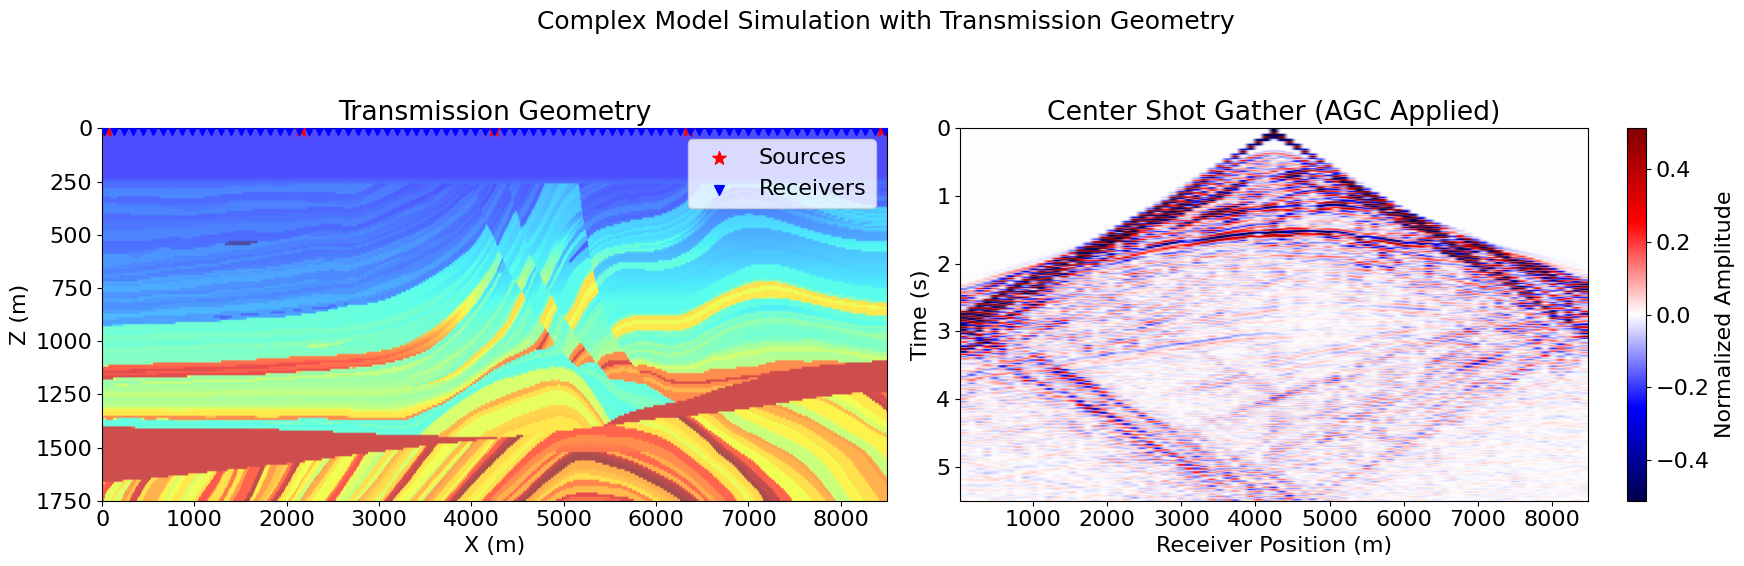


RUNNING ADJOINT AND GRADIENT TESTS

1. DOT TEST (Adjoint Verification with Simple Model)
----------------------------------------
Running forward pass to establish background wavefield for the Jacobian...


Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 0.21 s
Operator `Forward` ran in 0.22 s
Operator `Forward` ran in 0.22 s


Background wavefield established.
Computing <J*dm, d>...


Operator `Born` ran in 0.35 s
Operator `Born` ran in 0.34 s
Operator `Born` ran in 0.34 s


Computing <dm, J'*d>...


TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memo


Forward dot product:  <J*dm, d>   = -4.34242375e+13
Adjoint dot product:  <dm, J'*d>  = -4.34240896e+13
Relative difference: 3.40494861e-06
--> Adjoint test: PASSED

2. FWI GRADIENT COMPUTATION (Simple and Complex Cases)
----------------------------------------
Computing gradient for SIMPLE model...


Operator `Forward` ran in 0.23 s
Operator `Forward` ran in 0.21 s
Operator `Forward` ran in 0.21 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 0.21 s
Operator `Forward` ran in 0.21 s
Operator `Forward` ran in 0.21 s
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU


Computing gradient for COMPLEX model...


Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 0.21 s
Operator `Forward` ran in 0.21 s
Operator `Forward` ran in 0.22 s
Operator `Forward` ran in 0.22 s
Operator `Forward` ran in 0.21 s
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(

Gradient computations complete.


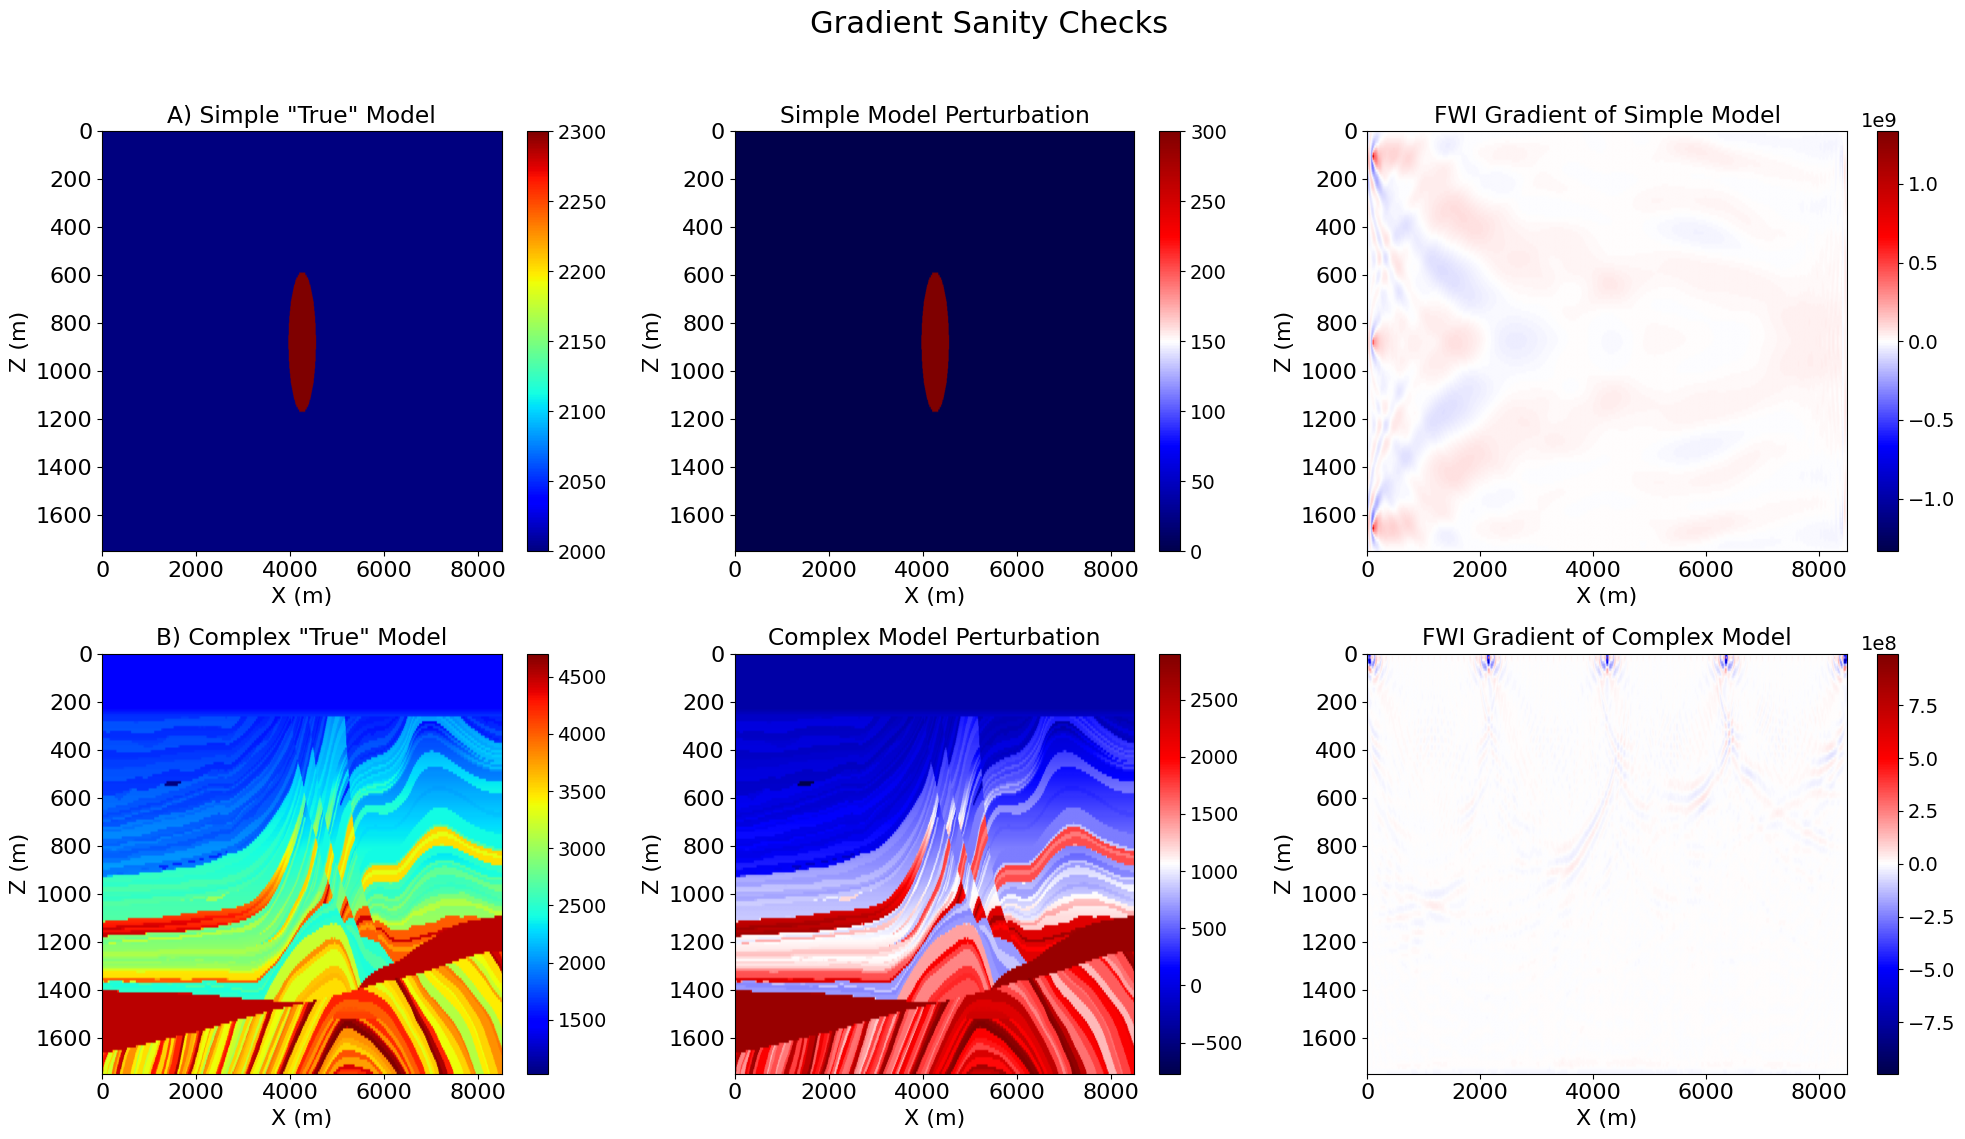

In [4]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Set up Devito environment and import necessary modules
from pydeviseis.core.environment import setup_for_fwi_demo
env_info = setup_for_fwi_demo(verbose=True)

from examples.seismic import Model
from pydeviseis.wave_equations.acoustic import AcousticWaveEquation
from pydeviseis.core.vector_adapters import DevitoVectorAdapter, MultiShotVectorAdapter
from GenericSolver.pyVector import vectorIC

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================
def create_complex_demo_model(nx=81, nz=81, dx=12.5, dz=12.5):
    """Create a more complex demonstration model for testing."""
    z = np.arange(nz) * dz; base_velocity = 1500 + 1.8 * z
    velocity = np.tile(base_velocity, (nx, 1))
    layer_info = [
        {'depth': 200, 'thickness': 40, 'vel_change': 400, 'lateral_var': 0.3},
        {'depth': 350, 'thickness': 60, 'vel_change': -250, 'lateral_var': 0.5},
        {'depth': 500, 'thickness': 80, 'vel_change': 600, 'lateral_var': 0.4},
        {'depth': 650, 'thickness': 50, 'vel_change': -300, 'lateral_var': 0.6}
    ]
    x = np.arange(nx) * dx
    for layer in layer_info:
        layer_z, thickness = int(layer['depth'] / dz), int(layer['thickness'] / dz)
        lateral_pattern = np.sin(x * 2 * np.pi / (nx * dx * layer['lateral_var']))
        z_variation = (thickness // 2) * lateral_pattern
        for ix in range(nx):
            start_z = max(0, layer_z + int(z_variation[ix]) - thickness//2)
            end_z = min(nz, start_z + thickness)
            velocity[ix, start_z:end_z] += layer['vel_change']
    fault_x, fault_width, fault_offset = nx // 3, nx // 20, nz // 15
    for ix in range(max(0, fault_x - fault_width), min(nx, fault_x + fault_width)):
        offset = int(fault_offset * (1 - abs(ix - fault_x) / fault_width))
        if offset > 0:
            velocity[ix, offset:] = velocity[ix, :-offset]
            velocity[ix, :offset] = velocity[ix, offset]
    center_x, center_z = int(2*nx/3), int(2*nz/3)
    intrusion_radius = min(nx, nz) // 12
    x_grid, z_grid = np.meshgrid(np.arange(nx), np.arange(nz), indexing='ij')
    intrusion_mask = ((x_grid - center_x)**2 + (z_grid - center_z)**2 < intrusion_radius**2)
    velocity[intrusion_mask] += 800
    velocity = np.clip(velocity, 1400, 4200)
    return DevitoVectorAdapter.numpy_to_vectorIC(velocity)

def create_simple_test_model(nx, nz, dx, dz, background_vp=2000.0, pert_vp=300.0):
    """Creates a constant background model with a central velocity perturbation."""
    model_array = np.full((nx, nz), background_vp, dtype=np.float32)
    center_x, center_z = (nx * dx) / 2, (nz * dz) / 2
    radius = min(nx * dx, nz * dz) / 6
    x_coords, z_coords = np.arange(nx) * dx, np.arange(nz) * dz
    x_grid, z_grid = np.meshgrid(x_coords, z_coords, indexing='ij')
    pert_mask = ((x_grid - center_x)**2 + (z_grid - center_z)**2 < radius**2)
    model_array[pert_mask] += pert_vp
    return DevitoVectorAdapter.numpy_to_vectorIC(model_array)

def create_symmetric_geometry(model_shape, model_spacing, n_sources=3, n_receivers=81):
    """Creates geometry with sources on the left and receivers on the right."""
    nx, nz = model_shape; dx, dz = model_spacing
    src_x = np.full(n_sources, dx * 10)
    src_z = np.linspace(dz * 10, dz * (nz - 10), n_sources)
    src_coordinates = np.column_stack([src_x, src_z])
    rec_x = np.full(n_receivers, dx * (nx - 10))
    rec_z = np.linspace(dz * 5, dz * (nz - 5), n_receivers)
    rec_coordinates = np.column_stack([rec_x, rec_z])
    return {'src_coordinates': src_coordinates, 'rec_coordinates': rec_coordinates}

def create_surface_survey_geometry(model_shape, model_spacing, n_sources, n_receivers, depth):
    """
    Creates a standard surface acquisition geometry with sources and receivers at a fixed depth.
    """
    nx, nz = model_shape
    dx, dz = model_spacing
    
    # Define source locations near the surface
    src_x = np.linspace(dx * 5, dx * (nx - 5), n_sources)
    src_z = np.full(n_sources, depth)
    src_coordinates = np.column_stack([src_x, src_z])
    
    # Define receiver locations near the surface
    rec_x = np.linspace(dx * 2, dx * (nx - 2), n_receivers)
    rec_z = np.full(n_receivers, depth)
    rec_coordinates = np.column_stack([rec_x, rec_z])
    
    return {'src_coordinates': src_coordinates, 'rec_coordinates': rec_coordinates}

def create_transmission_geometry(model_shape, model_spacing, n_sources=5, n_receivers=81):
    """Creates geometry with sources on top and receivers on the bottom."""
    nx, nz = model_shape; dx, dz = model_spacing
    src_x = np.linspace(dx * 5, dx * (nx-5), n_sources)
    src_z = np.full(n_sources, dz * 2)
    src_coordinates = np.column_stack([src_x, src_z])
    rec_x = np.linspace(dx * 2, dx * (nx-2), n_receivers)
    rec_z = np.full(n_receivers, dz * (nz - 2))
    rec_coordinates = np.column_stack([rec_x, rec_z])
    return {'src_coordinates': src_coordinates, 'rec_coordinates': rec_coordinates}

def apply_agc(data, window_len=100):
    """Applies Automatic Gain Control to the data."""
    agc_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        trace = data[:, i]; envelope = np.abs(hilbert(trace))
        rms = np.sqrt(np.convolve(envelope**2, np.ones(window_len)/window_len, 'same'))
        agc_data[:, i] = trace / (rms + 1e-10)
    return agc_data

# =============================================================================
# MAIN SCRIPT
# =============================================================================
# 1. MODEL AND GEOMETRY DEFINITION
# nx, nz = 81, 81; dx, dz = 12.5, 12.5
# model_shape = (nx, nz); model_spacing = (dx, dz); model_origin = (0., 0.)
true_model = DevitoVectorAdapter.numpy_to_vectorIC(np.load('/home/user/work/shared_stitt/research_2025/elastic_tests/models/elastic-marmousi-model/model/marmousi_vp_resampled_16ds.npy').T)
# true_model = create_complex_demo_model(nx, nz, dx, dz)
print(true_model.shape)
nx, nz = np.shape(true_model)[0], np.shape(true_model)[1]; dx, dz = 10, 10
model_shape = (nx, nz); model_spacing = (dx, dz); model_origin = (0., 0.)

# 2. AUTOMATIC TIME STEP CALCULATION
n_sources_complex = 5; n_receivers_complex = 81
f0 = 15.0; simulation_time_s = 5.5
print("\nCalculating optimal dt for stability based on the most complex model...")
temp_devito_model = Model(vp=true_model.getNdArray(), origin=model_origin, shape=model_shape,
                          spacing=model_spacing, space_order=4, nbl=40)
dt = temp_devito_model.critical_dt; nt = int(simulation_time_s / dt) + 1; tn = (nt - 1) * dt
print(f"  Consistent dt for all simulations: {dt:.6f} s, nt: {nt}")
print(f"  Total recording time: {tn:.2f} s")

# 3. FORWARD MODELING (using the complex model)
# geometry_complex = create_transmission_geometry(model_shape, model_spacing, n_sources_complex, n_receivers_complex)
geometry_complex = create_surface_survey_geometry(model_shape, model_spacing, n_sources_complex, n_receivers_complex, depth=10)
wave_eq = AcousticWaveEquation(model_shape, model_spacing)
geometry_params_complex = {**geometry_complex, 'nt': nt, 'dt': dt, 'f0': f0, 'multi_shot': True}
acoustic_op = wave_eq.create_operator(**geometry_params_complex)
print("\nRunning forward modeling with complex model and transmission geometry...")
observed_data_complex = MultiShotVectorAdapter.create_multishot_data_vector(n_sources_complex, nt, n_receivers_complex)
# *** FIX: Access the non-linear operator via the .nl_op attribute ***
acoustic_op.nl_op.forward(False, true_model, observed_data_complex)
print("Forward modeling completed!")

# Visualize the new geometry and shot gathers
rec_coords_complex = geometry_params_complex['rec_coordinates']
src_coords_complex = geometry_params_complex['src_coordinates']
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].imshow(true_model.getNdArray().T, aspect='auto', cmap='jet', alpha=0.7, extent=[0, nx*dx, nz*dz, 0])
axes[0].scatter(src_coords_complex[:, 0], src_coords_complex[:, 1], c='red', s=100, marker='*', label='Sources', zorder=5)
axes[0].scatter(rec_coords_complex[:, 0], rec_coords_complex[:, 1], c='blue', s=50, marker='v', label='Receivers', zorder=5)
axes[0].set_xlabel('X (m)'); axes[0].set_ylabel('Z (m)'); axes[0].set_title('Transmission Geometry'); axes[0].legend()
shot_data = observed_data_complex.vecs[n_sources_complex // 2].getNdArray()
# agc_shot_data = apply_agc(shot_data); vmax = np.percentile(agc_shot_data, 99)
vmax = np.percentile(shot_data, 99)
im = axes[1].imshow(shot_data, aspect='auto', cmap='seismic', vmin=-vmax, vmax=vmax,
                   extent=[rec_coords_complex[0, 0], rec_coords_complex[-1, 0], tn, 0])
axes[1].set_title(f'Center Shot Gather (AGC Applied)'); axes[1].set_xlabel('Receiver Position (m)'); axes[1].set_ylabel('Time (s)')
fig.colorbar(im, ax=axes[1], label='Normalized Amplitude')
plt.suptitle('Complex Model Simulation with Transmission Geometry', fontsize=18); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# 4. ADJOINT AND GRADIENT TESTS
# =============================
print("\n" + "=" * 60); print("RUNNING ADJOINT AND GRADIENT TESTS"); print("=" * 60)
# Test 1: DOT TEST with Simple Model
print("\n1. DOT TEST (Adjoint Verification with Simple Model)"); print("-" * 40)
n_sources_simple, n_receivers_simple = 3, 81
geometry_simple = create_symmetric_geometry(model_shape, model_spacing, n_sources_simple, n_receivers_simple)
geometry_params_simple = {**geometry_simple, 'nt': nt, 'dt': dt, 'f0': f0, 'multi_shot': True}
acoustic_op_simple = wave_eq.create_operator(**geometry_params_simple)
dot_test_model = create_simple_test_model(nx, nz, dx, dz)

# --- FIX: Run a forward pass to generate and save the required background wavefield ---
print("Running forward pass to establish background wavefield for the Jacobian...")
# We don't need the output data, we just need the side-effect of saving the wavefield.
d_ignore = MultiShotVectorAdapter.create_multishot_data_vector(n_sources_simple, nt, n_receivers_simple)
# Calling the NON-LINEAR forward operator will compute and save the wavefield inside the object.
acoustic_op_simple.nl_op.forward(False, dot_test_model, d_ignore)
print("Background wavefield established.")
# --- END FIX ---

# Now that the wavefield is saved inside the operator, we can proceed with the dot test.
dm = dot_test_model.clone(); dm.rand(); dm.scale(10.0)
d = MultiShotVectorAdapter.create_multishot_data_vector(n_sources_simple, nt, n_receivers_simple); d.rand()

print("Computing <J*dm, d>..."); Jdm = d.clone()
acoustic_op_simple.lin_op.jacobian(False, dm, Jdm)
dot1 = Jdm.dot(d)

print("Computing <dm, J'*d>..."); JTd = dot_test_model.clone()
acoustic_op_simple.lin_op.adjoint(False, JTd, d)
dot2 = dm.dot(JTd)

print(f"\nForward dot product:  <J*dm, d>   = {dot1:.8e}")
print(f"Adjoint dot product:  <dm, J'*d>  = {dot2:.8e}")
rel_diff = abs(dot1 - dot2) / max(1e-12, abs(dot1), abs(dot2))
print(f"Relative difference: {rel_diff:.8e}")
print(f"--> Adjoint test: {'PASSED' if rel_diff < 1e-5 else 'FAILED'}")

# Test 2: FWI GRADIENT COMPUTATION
print("\n2. FWI GRADIENT COMPUTATION (Simple and Complex Cases)"); print("-" * 40)
# Case A: Gradient for the simple model
print("Computing gradient for SIMPLE model...")
smooth_model_simple = dot_test_model.clone(); smooth_model_simple.set(2000.0)
observed_data_simple = d.clone(); acoustic_op_simple.set_background(dot_test_model)
acoustic_op_simple.nl_op.forward(False, dot_test_model, observed_data_simple)
pred_data_simple = d.clone(); acoustic_op_simple.set_background(smooth_model_simple)
acoustic_op_simple.nl_op.forward(False, smooth_model_simple, pred_data_simple)
data_residual_simple = pred_data_simple.clone(); data_residual_simple.scaleAdd(observed_data_simple, 1.0, -1.0)
gradient_simple = dot_test_model.clone(); acoustic_op_simple.set_background(smooth_model_simple)
acoustic_op_simple.lin_op.adjoint(False, gradient_simple, data_residual_simple)

# Case B: Gradient for the complex model
print("\nComputing gradient for COMPLEX model...")
smooth_model_complex = true_model.clone(); smooth_model_complex.set(1800.0)
acoustic_op.set_background(smooth_model_complex)
pred_data_complex = observed_data_complex.clone()
acoustic_op.nl_op.forward(False, smooth_model_complex, pred_data_complex)
data_residual_complex = pred_data_complex.clone(); data_residual_complex.scaleAdd(observed_data_complex, 1.0, -1.0)
gradient_complex = true_model.clone(); acoustic_op.set_background(smooth_model_complex)
acoustic_op.lin_op.adjoint(False, gradient_complex, data_residual_complex)
print("Gradient computations complete.")

# Plotting all results
fig, axes = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'width_ratios': [1, 1, 1.2]})
plt.rcParams.update({'font.size': 14}); extent_meters = [0, nx*dx, nz*dz, 0]
im = axes[0, 0].imshow(dot_test_model.getNdArray().T, aspect='auto', cmap='jet', extent=extent_meters); fig.colorbar(im, ax=axes[0, 0]); axes[0, 0].set_title('A) Simple "True" Model')
im = axes[0, 1].imshow((dot_test_model.getNdArray() - 2000.0).T, aspect='auto', cmap='seismic', extent=extent_meters); fig.colorbar(im, ax=axes[0, 1]); axes[0, 1].set_title('Simple Model Perturbation')
vmax_grad_simple = np.max(np.abs(gradient_simple.getNdArray()))
im = axes[0, 2].imshow(gradient_simple.getNdArray().T, aspect='auto', cmap='seismic', vmin=-vmax_grad_simple, vmax=vmax_grad_simple, extent=extent_meters); fig.colorbar(im, ax=axes[0, 2]); axes[0, 2].set_title('FWI Gradient of Simple Model')
im = axes[1, 0].imshow(true_model.getNdArray().T, aspect='auto', cmap='jet', extent=extent_meters); fig.colorbar(im, ax=axes[1, 0]); axes[1, 0].set_title('B) Complex "True" Model')
im = axes[1, 1].imshow((true_model.getNdArray() - 1800.0).T, aspect='auto', cmap='seismic', extent=extent_meters); fig.colorbar(im, ax=axes[1, 1]); axes[1, 1].set_title('Complex Model Perturbation')
vmax_grad_complex = np.max(np.abs(gradient_complex.getNdArray()))
im = axes[1, 2].imshow(gradient_complex.getNdArray().T, aspect='auto', cmap='seismic', vmin=-vmax_grad_complex, vmax=vmax_grad_complex, extent=extent_meters); fig.colorbar(im, ax=axes[1, 2]); axes[1, 2].set_title('FWI Gradient of Complex Model')
for ax_row in axes:
    for ax in ax_row: ax.set_xlabel('X (m)'); ax.set_ylabel('Z (m)')
plt.suptitle("Gradient Sanity Checks", fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.show()

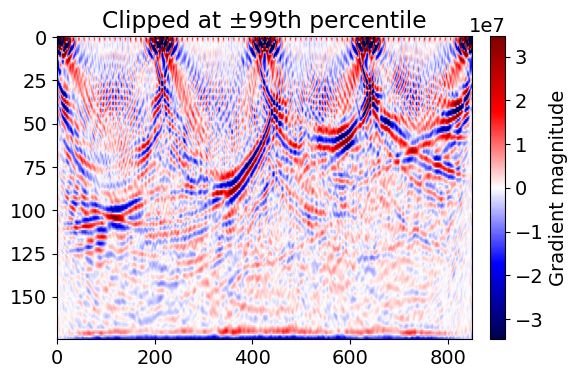

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# grab your data
data = gradient_complex.getNdArray().T

# compute symmetric clip‐point at the 99th percentile of abs(data)
clip = np.percentile(np.abs(data), 99)

fig, ax = plt.subplots(figsize=(6,4))

# use a diverging norm centered on zero
norm = TwoSlopeNorm(vcenter=0.0, vmin=-clip, vmax=clip)

im = ax.imshow(data,
               cmap='seismic',
               aspect='auto',
               norm=norm)

# make the colorbar a bit bigger and with some padding
cbar = plt.colorbar(im,
                    ax=ax,
                    fraction=0.046,  # fraction of parent axes
                    pad=0.04)        # space between image and colorbar
cbar.set_label('Gradient magnitude')

ax.set_title('Clipped at ±99th percentile')
plt.tight_layout()
plt.show()


## Cell below checks for boundary reflections

Operator `initdamp` ran in 0.01 s


Running forward model with guaranteed absorbing boundaries...


Operator `Forward` ran in 31.16 s


Done.


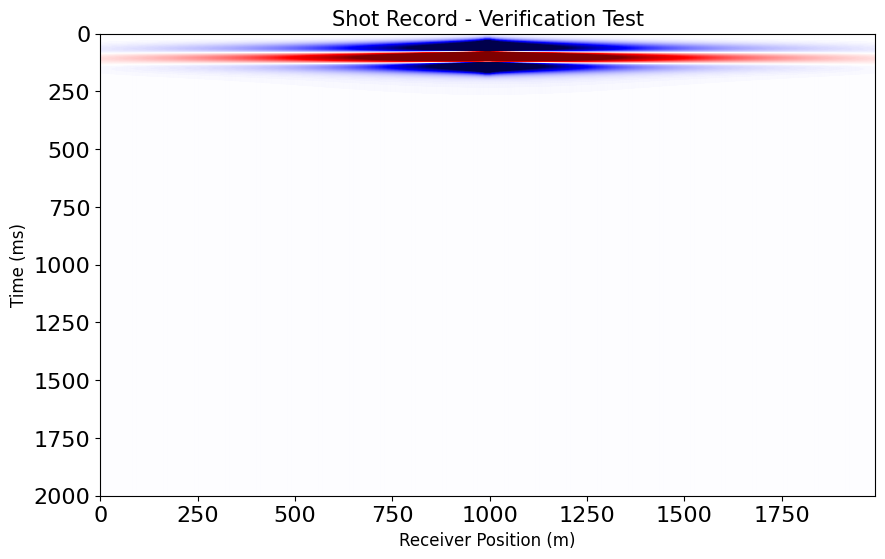

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from examples.seismic import Model, AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver


# =============================================================================
# 1. DEFINE A SIMPLE, GUARANTEED-CORRECT SETUP
# =============================================================================
shape = (200, 200)  # Physical model size (nz, nx)
spacing = (10., 10.) # Grid spacing in meters (dz, dx)
origin = (0., 0.)   # Physical model origin
nbl = 50           # Number of boundary layers - thick and robust
space_order = 8    # Higher space order for accuracy

# Create a simple, constant velocity model
# The values are transposed to match Devito's (nz, nx) convention
vp = np.full(shape, 2000.0, dtype=np.float32).T

# Create the Devito Model object
# This is the most critical step. Devito builds the absorbing boundary here.
model = Model(
    vp=vp,
    origin=origin,
    shape=shape,
    spacing=spacing,
    space_order=space_order,
    nbl=nbl,
    bcs="damp"  # Explicitly set the damping boundary condition
)

# =============================================================================
# 2. DEFINE GEOMETRY AND RUN FORWARD MODEL
# =============================================================================
t0 = 0.
tn = 2000.  # 2 seconds
dt = model.critical_dt
nt = int(1 + (tn-t0) / dt)

# Source in the center of the physical domain to test all boundaries
src_coords = np.empty((1, 2))
src_coords[0, 0] = model.domain_size[0] * 0.5
src_coords[0, 1] = 2 * spacing[1]  # z-depth of source (20m)

# Receivers across the top surface
nreceivers = shape[1]
rec_coords = np.empty((nreceivers, 2))
rec_coords[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coords[:, 1] = 2 * spacing[1] # z-depth of receivers (20m)

# Create the geometry and solver
geometry = AcquisitionGeometry(model, rec_coords, src_coords, t0=t0, tn=tn, f0=0.010, src_type='Ricker')
solver = AcousticWaveSolver(model, geometry, space_order=space_order)

print("Running forward model with guaranteed absorbing boundaries...")
rec, u, _ = solver.forward(save=False)
print("Done.")

# =============================================================================
# 3. VISUALIZE AND VERIFY
# =============================================================================
rec_data_np = np.array(rec.data)

plt.figure(figsize=(10, 6))
# Use the new NumPy array for all plotting and percentile calculations
plt.imshow(rec_data_np, aspect='auto', cmap='seismic', 
           vmin=-np.percentile(np.abs(rec_data_np), 99), 
           vmax=np.percentile(np.abs(rec_data_np), 99),
           extent=[0, model.domain_size[0], tn, t0])
plt.title("Shot Record - Verification Test", fontsize=15)
plt.xlabel("Receiver Position (m)", fontsize=12)
plt.ylabel("Time (ms)", fontsize=12)
plt.show()

## Cell below checks does a FWI test

Setting up environment for FWI demonstration...
Auto-detecting optimal Devito environment...
GPUs detected - setting up GPU environment
Setting up Devito environment for GPU execution...
  DEVITO_LANGUAGE = openacc
  DEVITO_ARCH = pgcc
  DEVITO_PLATFORM = nvidiaX
  DEVITO_LOGGING = INFO
  CC = pgcc
  CXX = g++
GPU Setup:
  CUDA_VISIBLE_DEVICES = 0
  ACC_DEVICE_NUM = 0
  Using 1 GPU(s): [0]
No Devito cache found to clear.
GPU Information:
  Driver version: 535.247.01
  CUDA version: 12.9
  Available GPUs: 1
    GPU 0: Tesla V100-SXM2-16GB (16384 MB)
Devito GPU environment setup completed.
Devito version: 4.8.19

Current Devito Environment:
  DEVITO_LANGUAGE: openacc
  DEVITO_ARCH: pgcc
  DEVITO_PLATFORM: nvidiaX
  DEVITO_LOGGING: INFO
  CC: pgcc
  CXX: g++
  CUDA_VISIBLE_DEVICES: 0
  ACC_DEVICE_TYPE: nvidia
  ACC_DEVICE_NUM: 0
  OMP_NUM_THREADS: Not set
1. Defining Model and Geometry
(850, 175)


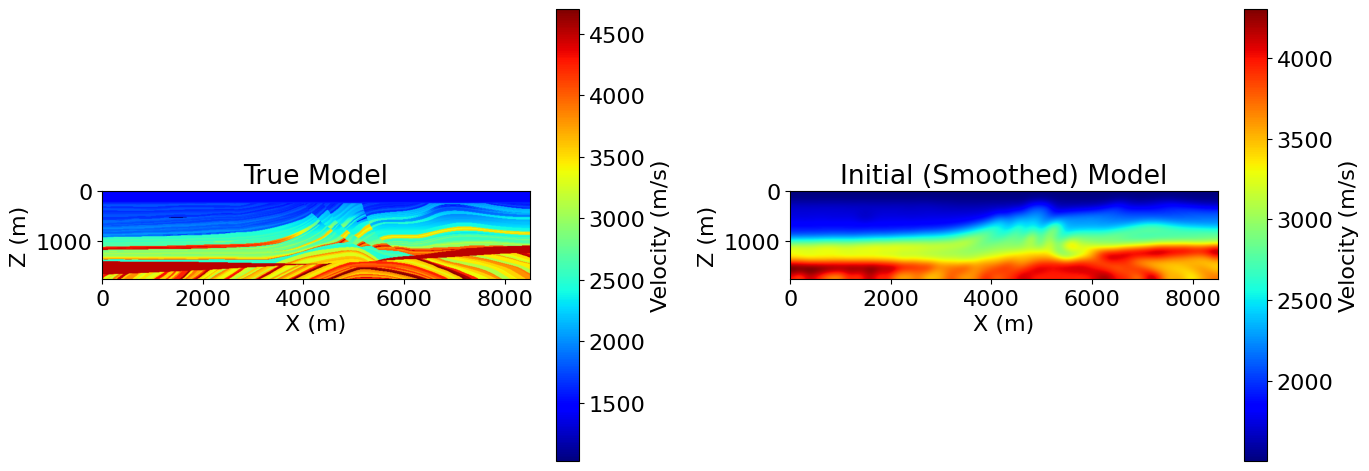


2. Defining Acquisition and Simulation Parameters


Operator `initdamp` ran in 0.01 s


  Total recording time: 3.50 s

3. Generating Synthetic Observed Data


Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
Time

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

project_path = os.path.abspath(os.getcwd()) 

# Add your project path to the front of the system's search path
if project_path not in sys.path:
    sys.path.insert(0, project_path)
    print(f"Added project path to sys.path: {project_path}")
# -----------------------------------------------------------------

# Now, all subsequent imports will correctly load from your local project files
from pydeviseis.core.environment import setup_for_fwi_demo
env_info = setup_for_fwi_demo(verbose=True)

from examples.seismic import Model
from pydeviseis.wave_equations.acoustic import AcousticWaveEquation
from pydeviseis.core.vector_adapters import DevitoVectorAdapter, MultiShotVectorAdapter
from GenericSolver.pyVector import vectorIC
from scipy.ndimage import gaussian_filter

from pydeviseis.inversion.fwi import DevitoFWI, BoundedFWIProblem

def create_smoothed_model(true_model, sigma=15):
    """
    Creates a smooth model with only the vertical velocity gradient
    by averaging the true model horizontally.
    """
    true_array = true_model.getNdArray()
    # # Calculate the average velocity for each depth level
    # avg_velocity_at_depth = np.mean(true_array, axis=0)
    # # Create the new model by tiling this 1D profile horizontally
    # gradient_array = np.tile(avg_velocity_at_depth, (true_array.shape[0], 1))
    smoothed_gradient_array = gaussian_filter(true_array, sigma=sigma)
    return DevitoVectorAdapter.numpy_to_vectorIC(smoothed_gradient_array)

def create_surface_geometry(model_shape, model_spacing, n_sources=5, n_receivers=81):
    """Creates a standard surface acquisition geometry."""
    nx, nz = model_shape; dx, dz = model_spacing
    src_depth = dz * 2; rec_depth = dz * 2
    src_x = np.linspace(dx * 5, dx * (nx-5), n_sources)
    src_z = np.full(n_sources, src_depth)
    src_coordinates = np.column_stack([src_x, src_z])
    rec_x = np.linspace(dx * 2, dx * (nx-2), n_receivers)
    rec_z = np.full(n_receivers, rec_depth)
    rec_coordinates = np.column_stack([rec_x, rec_z])
    return {'src_coordinates': src_coordinates, 'rec_coordinates': rec_coordinates}

def apply_agc(data, window_len=100):
    """Applies Automatic Gain Control to the data."""
    agc_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        trace = data[:, i]; envelope = np.abs(hilbert(trace))
        rms = np.sqrt(np.convolve(envelope**2, np.ones(window_len)/window_len, 'same'))
        agc_data[:, i] = trace / (rms + 1e-10)
    return agc_data

# 1. DEFINE MODEL AND GEOMETRY
# ----------------------------
print("1. Defining Model and Geometry")
# nx, nz = 101, 101; dx, dz = 10.0, 10.0
# model_shape = (nx, nz); model_spacing = (dx, dz); model_origin = (0., 0.)

# true_model = create_complex_demo_model(nx, nz, dx, dz)
true_model = DevitoVectorAdapter.numpy_to_vectorIC(np.load('/home/user/work/shared_stitt/research_2025/elastic_tests/models/elastic-marmousi-model/model/marmousi_vp_resampled_16ds.npy').T)
# true_model = create_complex_demo_model(nx, nz, dx, dz)
print(true_model.shape)
nx, nz = np.shape(true_model)[0], np.shape(true_model)[1]; dx, dz = 10, 10
model_shape = (nx, nz); model_spacing = (dx, dz); model_origin = (0., 0.)
initial_model = create_smoothed_model(true_model, sigma=10)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
extent_m = [0, nx*dx, nz*dz, 0]
im = axes[0].imshow(true_model.getNdArray().T, cmap='jet', extent=extent_m); fig.colorbar(im, ax=axes[0], label='Velocity (m/s)'); axes[0].set_title('True Model')
im = axes[1].imshow(initial_model.getNdArray().T, cmap='jet', extent=extent_m); fig.colorbar(im, ax=axes[1], label='Velocity (m/s)'); axes[1].set_title('Initial (Smoothed) Model')
for ax in axes: ax.set_xlabel('X (m)'); ax.set_ylabel('Z (m)')
plt.tight_layout(); plt.show()


# 2. DEFINE ACQUISITION AND SIMULATION PARAMETERS
# -----------------------------------------------
print("\n2. Defining Acquisition and Simulation Parameters")
n_sources = 5; n_receivers = 101
f0 = 15.0; simulation_time_s = 3.5
temp_devito_model = Model(vp=true_model.getNdArray(), origin=model_origin, shape=model_shape,
                          spacing=model_spacing, space_order=4, nbl=200)
dt = temp_devito_model.critical_dt; nt = int(simulation_time_s / dt) + 1; tn = (nt - 1) * dt
print(f"  Total recording time: {tn:.2f} s")
geometry = create_surface_geometry(model_shape, model_spacing, n_sources, n_receivers)
geometry_params = {**geometry, 'nt': nt, 'dt': dt, 'f0': f0, 'multi_shot': True}


# 3. GENERATE SYNTHETIC "TRUE" DATA
# ---------------------------------
print("\n3. Generating Synthetic Observed Data")
wave_eq = AcousticWaveEquation(model_shape, model_spacing)
acoustic_op = wave_eq.create_operator(**geometry_params)
observed_data = MultiShotVectorAdapter.create_multishot_data_vector(n_sources, nt, n_receivers)

# *** FIX: Access the non-linear operator via the .nl_op attribute ***
acoustic_op.set_background(true_model)  # Set background first
acoustic_op.nl_op.forward(False, true_model, observed_data)
print("  Forward modeling complete.")

# Visualize the synthetic shot gathers
fig, axes = plt.subplots(1, n_sources, figsize=(20, 7), sharey=True)
if n_sources == 1: axes = [axes]
rec_coords = geometry_params['rec_coordinates']
for i in range(n_sources):
    shot_data = observed_data.vecs[i].getNdArray()
    vmax = np.percentile(shot_data, 99)
    # agc_shot_data = apply_agc(shot_data); vmax = np.percentile(agc_shot_data, 99)
    im = axes[i].imshow(shot_data, aspect='auto', cmap='seismic', vmin=-vmax, vmax=vmax,
                       extent=[rec_coords[0, 0], rec_coords[-1, 0], tn, 0])
    axes[i].set_title(f'Shot {i+1}', fontsize=14); axes[i].set_xlabel('Receiver Position (m)', fontsize=12)
axes[0].set_ylabel('Time (s)', fontsize=12)
plt.suptitle('Synthetic Observed Data (AGC Applied)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


# 4. RUN MULTI-FREQUENCY FWI
# --------------------------
print("\n4. Running Multi-Frequency FWI")
frequency_bands = [(3.0, 8.0), (3.0, 12.0)]
iterations_per_band = [20, 20]

fwi = DevitoFWI(wave_equation=wave_eq, observed_data=observed_data,
                geometry_params=geometry_params,
                solver_type='lbfgs',
                stepper_type='strongwolfe',
                frequency_bands=frequency_bands,
                iterations_per_band=iterations_per_band)

current_model = initial_model.clone()
for i in range(len(frequency_bands)):
    print("\n" + "="*60); print(f"INVERTING FREQUENCY BAND {i+1}/{len(frequency_bands)}"); print("="*60)
    
    results_band = fwi.run_single_frequency(initial_model=current_model, band_index=i)
    current_model = results_band['final_model'].clone()
    
    # Get the final gradient for visualization
    temp_geom_params = geometry_params.copy()
    temp_geom_params['f0'] = results_band['center_frequency']
    temp_op = wave_eq.create_operator(**temp_geom_params)
    
    problem = BoundedFWIProblem(model=current_model, observed_data=observed_data, 
                                acoustic_operator=temp_op,
                                vmin=1500, vmax=4200)
    final_grad = problem.get_grad(current_model)
    
    # Plot the results for the current band
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    vmax_grad = np.percentile(np.abs(final_grad.getNdArray()), 99.5)
    im = axes[0].imshow(current_model.getNdArray().T, cmap='jet', extent=extent_m); fig.colorbar(im, ax=axes[0], label='Velocity (m/s)')
    im = axes[1].imshow(final_grad.getNdArray().T, cmap='seismic', vmin=-vmax_grad, vmax=vmax_grad, extent=extent_m); fig.colorbar(im, ax=axes[1], label='Gradient Amplitude')
    axes[0].set_title(f'Updated Model - Band {i+1}'); axes[0].set_xlabel('X (m)'); axes[0].set_ylabel('Z (m)')
    axes[1].set_title(f'Final Gradient - Band {i+1}'); axes[1].set_xlabel('X (m)'); axes[1].set_ylabel('Z (m)')
    plt.suptitle(f'Results for Frequency Band: {frequency_bands[i][0]:.1f} - {frequency_bands[i][1]:.1f} Hz', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# 5. FINAL RESULTS VISUALIZATION
# ------------------------------
print("\n" + "="*60); print("FINAL FWI RESULTS"); print("="*60)

final_model = current_model.clone()
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
im = axes[0].imshow(true_model.getNdArray().T, cmap='jet', extent=extent_m); fig.colorbar(im, ax=axes[0], label='Velocity (m/s)'); axes[0].set_title('True Model')
im = axes[1].imshow(initial_model.getNdArray().T, cmap='jet', extent=extent_m); fig.colorbar(im, ax=axes[1], label='Velocity (m/s)'); axes[1].set_title('Initial Model')
im = axes[2].imshow(final_model.getNdArray().T, cmap='jet', extent=extent_m); fig.colorbar(im, ax=axes[2], label='Velocity (m/s)'); axes[2].set_title('Final Inverted Model')
for ax in axes: ax.set_xlabel('X (m)'); ax.set_ylabel('Z (m)')
plt.tight_layout(); plt.show()

### Cells below do the fwi example from devito

Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s


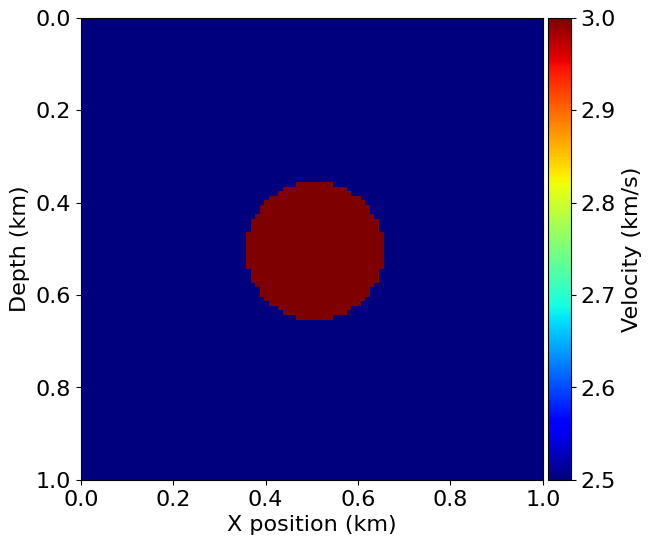

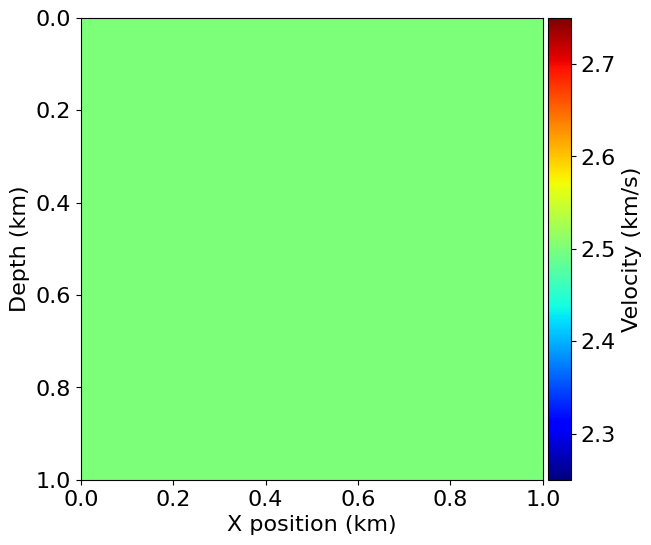

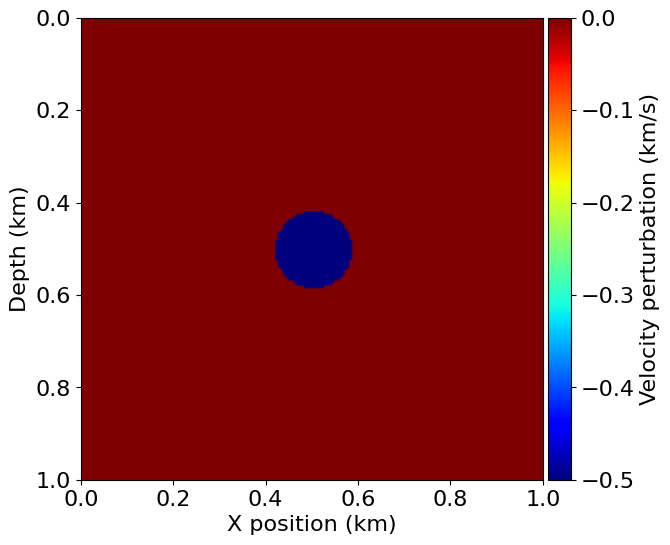

In [8]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

#NBVAL_IGNORE_OUTPUT
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                     grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

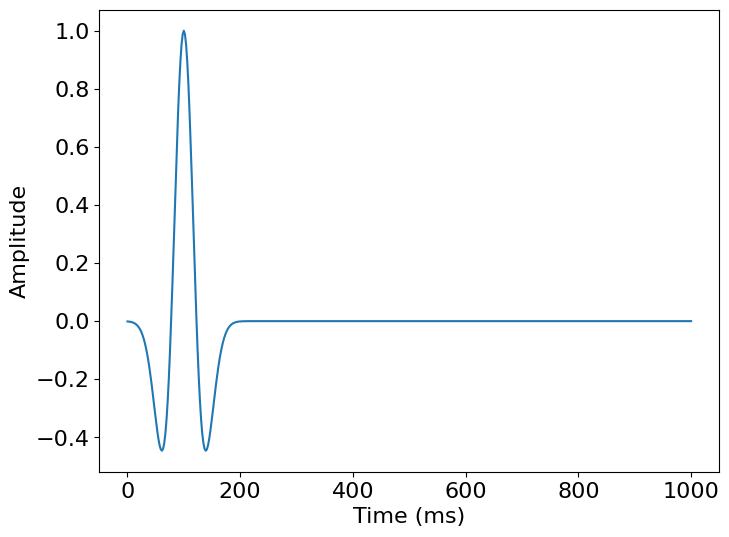

In [9]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

t0 = 0.
tn = 1000. 
f0 = 0.010
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 0] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.03 s


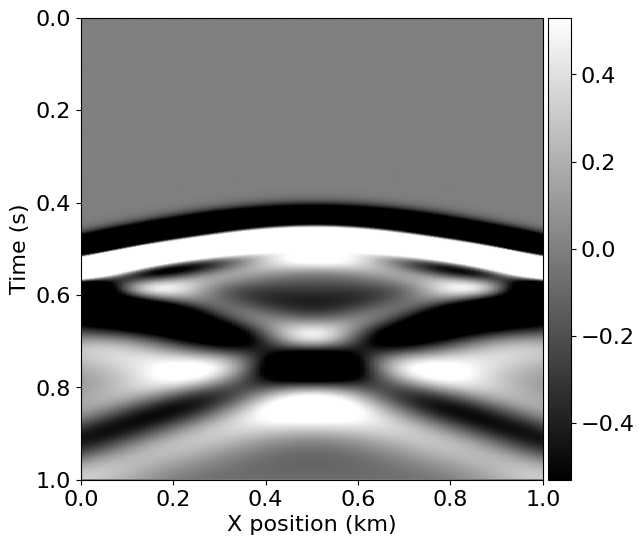

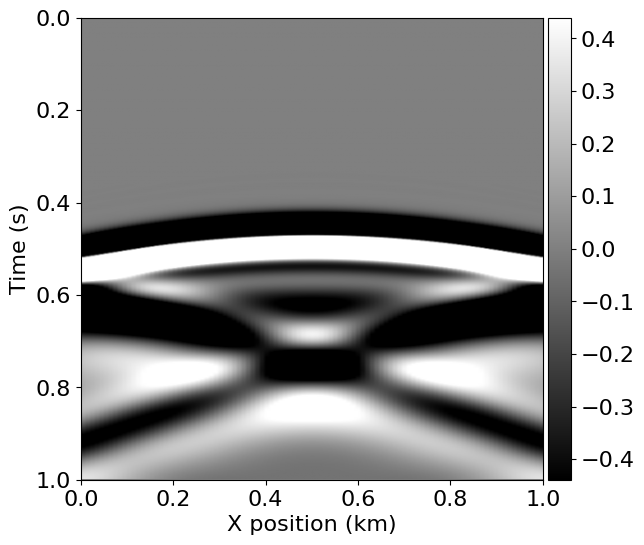

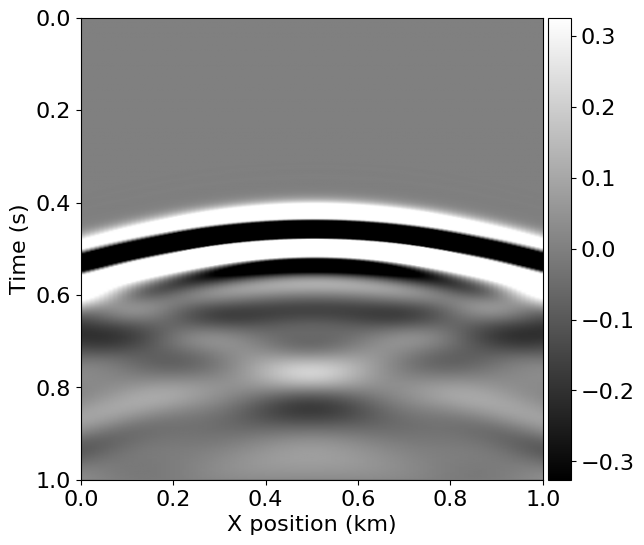

In [10]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

In [11]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

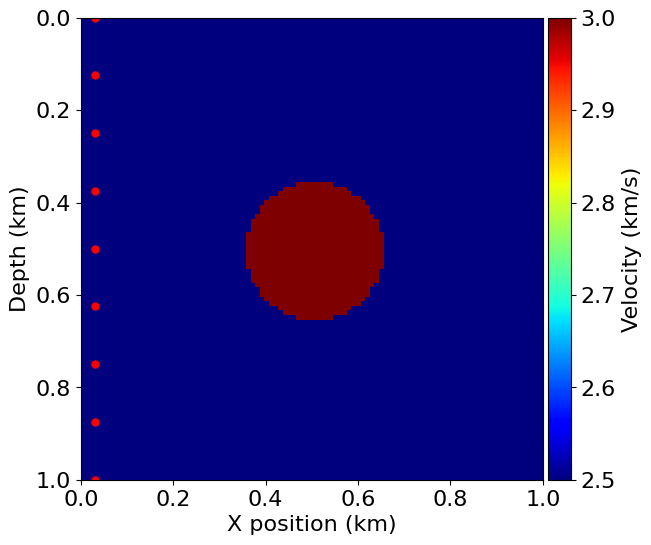

In [13]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

Operator `Forward` ran in 0.03 s
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x

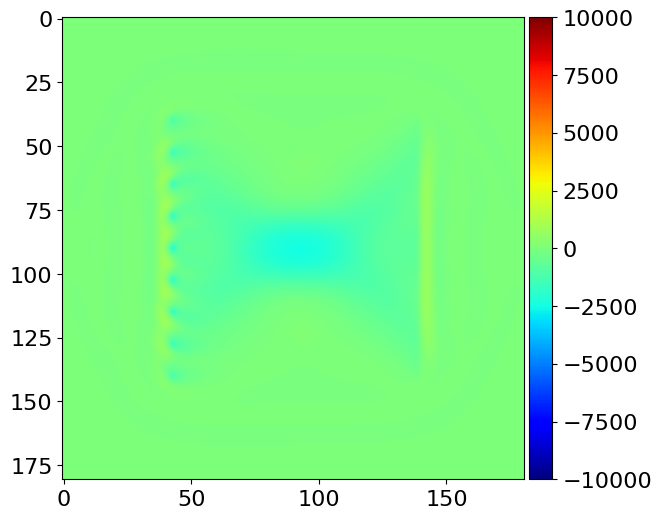

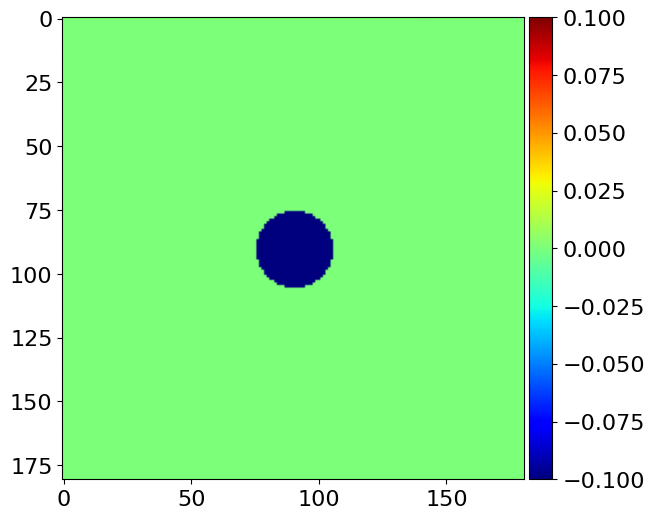

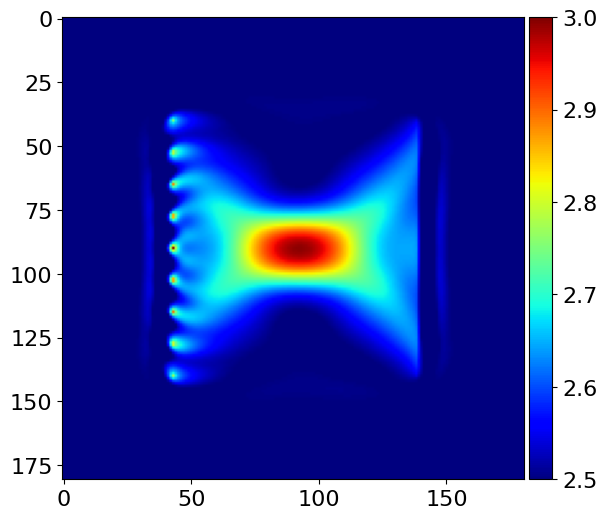

In [14]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
assert np.isclose(ff, 57283, rtol=1e0)
#NBVAL_IGNORE_OUTPUT
from devito import mmax
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

In [15]:
from devito import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()
#NBVAL_SKIP

from devito import mmax

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / mmax(direction)
    
    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.06 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.06 s


Objective value is 39293.789062 at iteration 1


Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.06 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.06 s


Objective value is 24505.765625 at iteration 2


Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.06 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s


Objective value is 14386.126953 at iteration 3


Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.06 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.06 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Kernel` ran in 0.01 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s


Objective value is 7907.253906 at iteration 4


Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.06 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Forward` ran in 0.02 s
Operator `Forward` ran in 0.05 s
Operator `Gradient` ran in 0.04 s
Operator `Kernel` ran in 0.01 s


Objective value is 3959.893066 at iteration 5


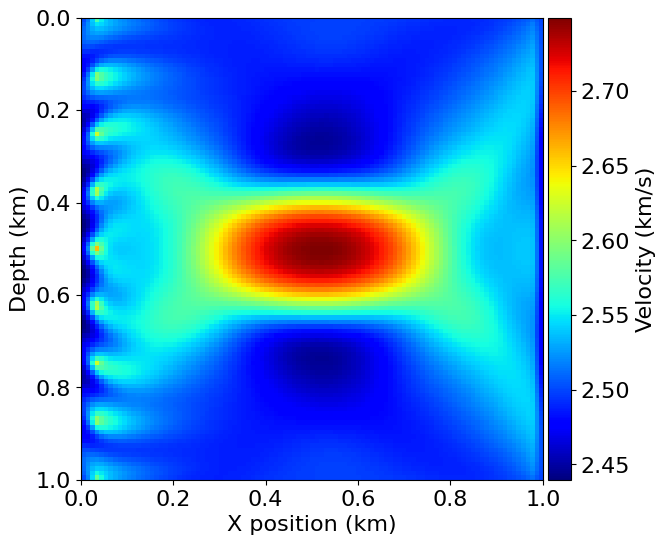

In [16]:
#NBVAL_IGNORE_OUTPUT

# Plot inverted velocity model
plot_velocity(model0)